In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [134]:
"""
This method splits the strings in RQs into a list of items.

These items can be areas and subareas of research.
"""

def split_areas(input_data, lv1_sep = ";"):
    return input_data.split(lv1_sep)

def _split_sub_areas(input_data, lv2_sep = ",", area_sub_sep = ":"):
    split_result = input_data.split(lv2_sep)
    if len(split_result) == 1:
        return [input_data.strip()]
    else:
        sub_areas = []
        area_name = split_result[0].split(area_sub_sep)[0].strip()
        # The first item has the format area:subarea, while the rest does not have area.
        # Try to split the string by : and grab the second part.
        # If it is possible, then we are processing the first element.
        # If we have error, it means we are processing the rest of the elements.
        for sub in split_result:
            try:
                sub_areas.append("%s:%s" % (area_name, sub.split(area_sub_sep)[1].strip().lower()))
            except IndexError:
                sub_areas.append("%s:%s" % (area_name, sub.strip().lower()))
        return sub_areas
    
def split_sub_areas(input_data, lv2_sep = ",", area_sub_sep = ":"):
    split_result = input_data.split(lv2_sep)
    sub_areas = []
    
    # Set the area name only if we can find the colon
    area_name = ""
    if split_result[0].find(":") != -1:
        area_name = split_result[0].split(area_sub_sep)[0].strip()
        
    for sub in split_result:
        sub_area = ""
        
        # The first item has the format area:subarea, while the rest does not have area.
        # Try to split the string by : and grab the second part.
        # If it is possible, then we are processing the first element.
        # If we have error, it means we are processing the rest of the elements.
        try:
            sub_area = sub.split(area_sub_sep)[1].strip().lower()
            
        except IndexError:
            sub_area = sub.strip().lower()        
        # Return the sub_area as is if there is no area name
        if area_name == "":
            sub_areas.append(sub_area)
        else:
            sub_areas.append("%s:%s" % (area_name, sub_area))
        
    return sub_areas

def split_input_data(input_data, split_areas = split_areas, split_sub_areas = split_sub_areas):
    results = []
    areas = split_areas(input_data)
    for area in areas:
        results.extend(split_sub_areas(area))
    return results

In [135]:
"""
Create relation between papers and values of an RQ
"""

def create_relation_paper_RQ(raw_df, rq_name_in_df, rq_display_name):
    # prepare an empty data frame
    paper_ids = []
    titles = []
    years = []
    venues = []
    types = []
    problem_areas = []
    data = {
        "Paper ID" : paper_ids,
        "Title" : titles,
        "Year" : years,
        "Venue" : venues,
        "Type" : types,
        rq_display_name : problem_areas
    }

    # apply text split
    rq_lists = raw_df[rq_name_in_df].apply(split_input_data)
    

    # construct the data frame
    for i in range(len(rq_lists)):
        for rq_value in rq_lists[i]:
            paper_ids.append(raw_df["Paper ID"][i])
            titles.append(raw_df["Title"][i])
            years.append(raw_df["Year"][i])
            venues.append(raw_df["Venue"][i])
            types.append(raw_df["Type"][i])
            problem_areas.append(rq_value)


    paper_rq_relation = pd.DataFrame(data)
    paper_rq_relation.sort_values(rq_display_name)
    return paper_rq_relation

In [136]:
def draw_countplot(data, column, size = (10, 8)):
    sns.countplot(y = column, data = data, orient="v", palette="coolwarm", 
              order = paper_rq1_relation[column].value_counts().index)
    ax1 = plt.gca()
    ax1.yaxis.label.set_visible(False)
    ax1.xaxis.label.set_visible(False)
    fig = plt.gcf()
    fig.set_size_inches(*size)
    plt.show()

In [137]:
"""
Creating relations between two RQs
"""

def create_relation(data, column_A_in_df, column_A_display, column_B_in_df, column_B_display):
    column_A_lists = data[column_A_in_df].apply(split_input_data)
    column_B_lists = data[column_B_in_df].apply(split_input_data)

    relations_list = []
    for i in range(len(column_A_lists)):
        column_A_values = column_A_lists[i]
        column_B_values = column_B_lists[i]
        for column_A_value in column_A_values:
            for column_B_value in column_B_values:
                relations_list.append((column_A_value, column_B_value))
    
    # Create data frame. Each column holds items from one RQ
    A, B = zip(*relations_list)
    data = {
        column_A_display : A,
        column_B_display : B
    }
    return pd.DataFrame(data)


In [138]:
import networkx as nx

def load(df):
    G = nx.Graph()
    count = 0
    for row in df.iterrows():
        node_A = row[1][0]
        node_B = row[1][1]
        if G.has_edge(node_A, node_B):
            # we added this one before, just increase the weight by one
            G[node_A][node_B]['weight'] += 1
        else:
            # new edge. add with weight=1
            G.add_edge(node_A, node_B, weight=1)
        count += 1
        """
        if count == 5:
            break
        """
    return G

In [139]:
"""
Loads the extracted data
"""

raw_path = "extraction_Q1_91_13-12.xlsx"
raw_df = pd.read_excel(raw_path)
raw_df

,Paper ID,Title,Year,Venue,Type,RQ1: Problem Area,RQ1: Technical Issue,RQ2: Replace or add,RQ2: Affected component,RQ2: Utlized BC character,RQ2: Ledger location,RQ2: Mining node selection scheme,RQ2: Consensus algorithm,RQ3: Perceived challenge,RQ3: Carried out BC optimisation,Note
0,Zhang:2015:1,An IoT Electric Business Model Based on the Pr...,2015,ICIN 2015,Conference,Enabling private ownership and exchange of IoT...,Remove centralised trusted intermediary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ouaddah:2016,FairAccess: a new Blockchain-based access cont...,2016,Security and Communication Networks,Journal,"Security: confidentiality, integrity, authenti...",Provide privacy-preserving access control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Samaniego:2016:1,Using blockchain to push software-defined IoT ...,2016,ACM International Conference Proceeding Series,Conference,Performance: Time behaviour,Control the distribution of IoT services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ali:2017:1,The quest for fully smart autonomous business ...,2017,ACM International Conference Proceeding Series,Conference,Enabling IoT service discovery (spatial or sem...,Provide cross IoT platform identity management...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ali:2017:2,IoT data privacy via blockchains and IPFS,2017,ACM International Conference Proceeding Series,Conference,"Security: non-repudiation, accountability; Ena...",Remove centralised trusted intermediary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Boudguiga:2017:1,Towards better availability and accountability...,2017,Proceedings of the 2nd IEEE European Symposium...,Workshop,Reliability: Availability; Security: Integrity...,Distribute software patches to devices,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Daza:2017:1,CONNECT: CONtextual NamE disCovery for blockch...,2017,Proceedings of IEEE International Conference o...,Conference,Enabling IoT service discovery (spatial or sem...,Remove centralised trusted intermediary; Allow...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Dorri:2017:2,Towards an optimized blockchain for IoT,2017,Proceedings of the 2nd International Conferenc...,Conference,"Security: confidentiality, integrity, authenti...",Remove centralised trusted intermediary; Prote...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Kaga:2017:1,A secure and practical signature scheme for bl...,2017,Lecture Notes in Computer Science (including s...,Journal,Security: authenticity,Ensuring that the user of a private key is its...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Lee:2017:1,Blockchain-based secure firmware update for em...,2017,Journal of Supercomputing,Journal,Reliability: Availability; Security: Integrity...,Distribute software patches to devices,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 16 columns):
Paper ID                             90 non-null object
Title                                90 non-null object
Year                                 90 non-null int64
Venue                                90 non-null object
Type                                 90 non-null object
RQ1: Problem Area                    90 non-null object
RQ1: Technical Issue                 90 non-null object
RQ2: Replace or add                  0 non-null float64
RQ2: Affected component              0 non-null float64
RQ2: Utlized BC character            0 non-null float64
RQ2: Ledger location                 0 non-null float64
RQ2: Mining node selection scheme    0 non-null float64
RQ2: Consensus algorithm             0 non-null float64
RQ3: Perceived challenge             0 non-null float64
RQ3: Carried out BC optimisation     0 non-null float64
Note                                 1 non-null object
dty

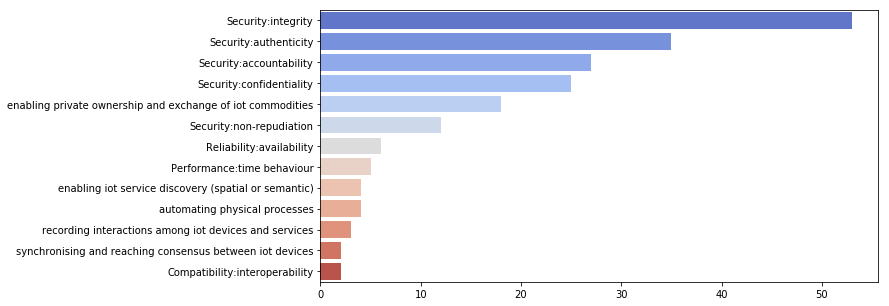

In [141]:
"""
Countplot of problem areas
"""
paper_rq1_relation = create_relation_paper_RQ(raw_df, "RQ1: Problem Area", "RQ1_Problem_Area")
draw_countplot(paper_rq1_relation, "RQ1_Problem_Area", size = (10,5))

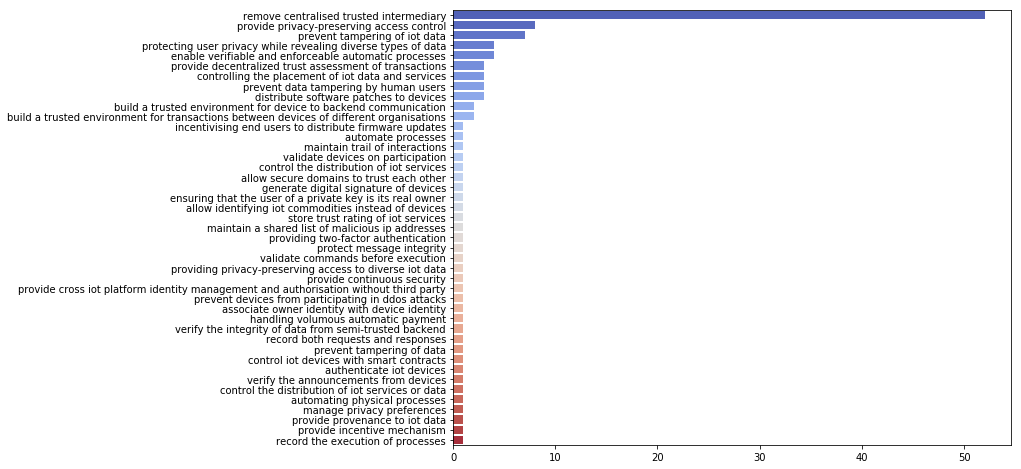

In [142]:
"""
Countplot of technical issues
"""
paper_rq1_relation = create_relation_paper_RQ(raw_df, "RQ1: Technical Issue", "RQ1_Technical_Issue")
draw_countplot(paper_rq1_relation, "RQ1_Technical_Issue")

In [143]:
"""
Create relation between RQ1: Problem area, and RQ1: Technical issues
"""
relation_df = create_relation(data = raw_df, column_A_in_df = "RQ1: Problem Area", column_A_display = "RQ1_Problem_Area", column_B_in_df = "RQ1: Technical Issue", column_B_display = "RQ1_Technical_Issue")

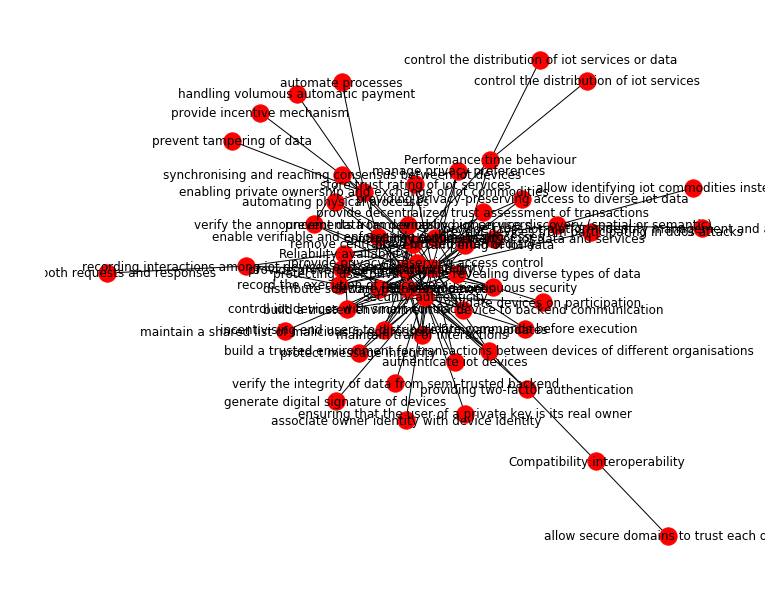

In [144]:
G = load(relation_df)
fig = plt.gcf()
fig.set_size_inches(10, 8)
nx.draw(G, with_labels=True)

plt.show()